## 🧩 Multi-Agent Collaboration — Summary

### ⚙️ Core Idea
- **Why**: Single (monolithic) agents struggle with complex, multi-domain tasks.  
- **Solution**: Break down tasks → assign to **specialized agents** → collaborate via shared protocols.  
- **Goal**: Achieve outcomes beyond what one agent can do alone.

---

### 🧠 Key Principle — *Task Decomposition*
High-level goal → Sub-tasks → Assigned to agents with matching tools or knowledge.  
**Example:**  
Research → Analysis → Synthesis handled by separate agents.

---

### 🔄 Collaboration Models
1. **Sequential Handoff** – Agent A → B → C (pipeline style).  
2. **Parallel Processing** – Agents work concurrently on different sub-tasks.  
3. **Debate & Consensus** – Agents argue and agree on best outcome.  
4. **Hierarchical** – Manager agent delegates and integrates results.  
5. **Expert Teams** – Domain specialists (e.g., researcher, writer, editor).  
6. **Critic–Reviewer** – Creator + Reviewer agents for quality control (esp. code, research, compliance).

---

### 🧩 Communication Essentials
- Needs **shared ontology** + **standard message protocol**.  
- Ensures coherence and enables delegation, coordination, and knowledge exchange.

---

### 🚀 Benefits
- **Modular** (replace agents easily)  
- **Scalable** (add more agents as needed)  
- **Robust** (failure-tolerant)  
- **Higher Quality Output** (cross-validation and specialization)

---

### 🏗️ Common Frameworks
- **CrewAI**, **Google ADK** → define agents, tasks, communication flows.

---

### 💡 Practical Use Cases
- **Research & Analysis** – agents for search, summarize, synthesize.  
- **Software Development** – requirement → code → test → doc chain.  
- **Creative Generation** – marketing or content teams (text, image, scheduling).  
- **Finance** – data fetch, sentiment, technical analysis, recommendations.  
- **Customer Support** – escalation chains (frontline → specialist).  
- **Supply Chain / Network Ops** – agents optimize logistics or remediate failures.

---

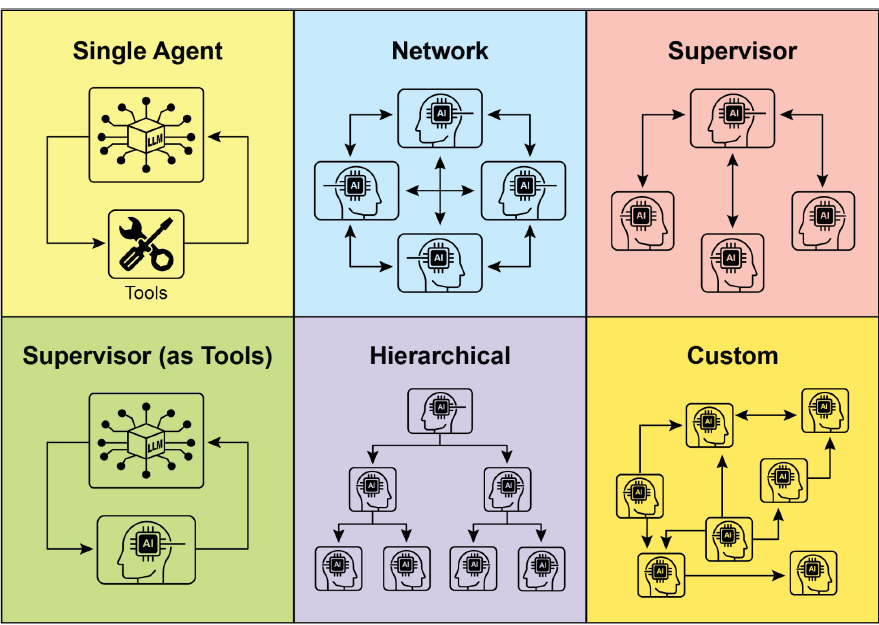

### 🕸️ Communication Models Spectrum
| Model | Description | Pros | Cons |
|--------|--------------|------|------|
| **Single Agent** | Works alone | Simple | Limited |
| **Network (Peer-to-Peer)** | Agents talk directly | Resilient | Coordination overhead |
| **Supervisor** | One controls others | Clear control | Single point of failure |
| **Supervisor-as-Tool** | Supervisor offers guidance/resources | Balanced | Less autonomy |
| **Hierarchical** | Multi-level supervisors | Scalable | Complex |
| **Custom** | Hybrid or domain-specific | Flexible | Harder to design |

---

### 🧭 Design Takeaway
Choose the **interaction model** based on:
- Task complexity  
- Autonomy needed  
- Number of agents  
- Robustness vs. coordination overhead  

---

### 🧩 TL;DR
> **Multi-Agent Collaboration = Specialized agents + Shared communication + Coordinated synergy → scalable, fault-tolerant, intelligent systems.**



## Supervisor Pattern

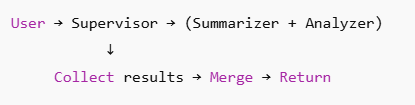

In [1]:
from typing import Annotated, TypedDict, Any, Optional
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import START, END, StateGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.errors import InvalidUpdateError

from IPython.display import display, Image

import operator
from datetime import datetime

from langchain_tavily import TavilySearch


In [2]:
load_dotenv()

True

In [22]:
# Define state structure
class AgentState(TypedDict, total=False):
    input_text: str
    summary: str
    analysis: str
    final_report: str

In [23]:
llm_summarizer = ChatOpenAI(model="gpt-4o-mini")
llm_analyzer = ChatOpenAI(model="gpt-4o-mini")
llm_supervisor = ChatOpenAI(model="gpt-4o-mini")

### Define Subordinate Agents

In [24]:
# --- Define Subordinate Agents ---
def summarizer_agent(state: AgentState):
    """Summarizes the input text."""        
    text = state["input_text"]
    summary = llm_summarizer.invoke(f"Summarize this text in 3 sentences:\n{text}")
    return {"summary": summary.content, "input_text": text}

In [25]:
# --- Define Subordinate Agents ---
def analyzer_agent(state: AgentState):
    """Performs a quick sentiment or quality analysis."""    
    text = state["input_text"]
    analysis = llm_analyzer.invoke(f"Analyze the key insights or sentiment of this text:\n{text}")
    return {"analysis": analysis.content, "input_text": text}

### Define Supervisor Agent

In [26]:
def supervisor_agent(state: AgentState):
    summary = state.get("summary")
    analysis = state.get("analysis")
    input_text = state.get("input_text", "")

    # Supervisor reasoning prompt
    supervisor_prompt = f"""
    You are a Supervisor Agent managing subordinate agents for summarization and analysis.
    The user asked: "{state['input_text'][:120]}..."

    Current known state:
    - Summary: {summary or "❌ Not yet done"}
    - Analysis: {analysis or "❌ Not yet done"}

    Decide what should happen next:
    - "summarizer" → if no summary or summary is poor
    - "analyzer" → if no analysis or more insights needed
    - "complete" → if both are done or results are sufficient

    Respond only with one keyword: summarizer, analyzer, or complete.
    """

    decision = llm_supervisor.invoke(supervisor_prompt).content.strip().lower()
    print(f"[SUPERVISOR DECISION] → {decision}")

    if "complete" in decision:
        combined = f"Summary:\n{summary}\n\nAnalysis:\n{analysis}\n\nSupervisor Review: Looks coherent and ready."
        return {"final_report": combined, "next_node": END}
    elif "analyzer" in decision:
        return {"next_node": "analyzer", "input_text": input_text}
    else:
        return {"next_node": "summarizer", "input_text": input_text}

### Build Graph

In [27]:
# --- Build the Graph ---
graph = StateGraph(AgentState)
graph.add_node("supervisor", supervisor_agent)
graph.add_node("summarizer", summarizer_agent)
graph.add_node("analyzer", analyzer_agent)

graph.add_edge(START, "supervisor")
graph.add_conditional_edges(
    "supervisor",
    lambda state: state["next_node"],
    {
        "summarizer": "summarizer",
        "analyzer": "analyzer",
        END: END,
    },
)
graph.add_edge("summarizer", "supervisor")
graph.add_edge("analyzer", "supervisor")

workflow = graph.compile()

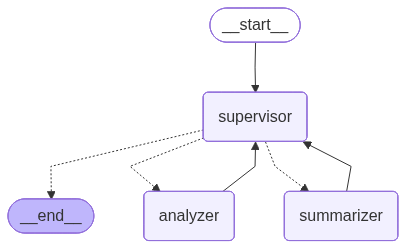

In [28]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [29]:
input_text = """
    Artificial intelligence is transforming industries worldwide.
    While it offers productivity gains, it also brings ethical and employment challenges.
    Governments seek to balance innovation with responsibility.
    """

In [30]:
result = workflow.invoke({"input_text": input_text})

[SUPERVISOR DECISION] → summarizer
[SUPERVISOR DECISION] → analyzer
[SUPERVISOR DECISION] → complete


In [31]:
print("\n\n--- FINAL OUTPUT ---\n")
print(result["final_report"])



--- FINAL OUTPUT ---

Summary:
Artificial intelligence is revolutionizing various industries by enhancing productivity. However, it also poses ethical dilemmas and employment challenges. As a result, governments are striving to find a balance between fostering innovation and ensuring responsible usage.

Analysis:
The text presents a balanced view of the impact of artificial intelligence (AI) on various industries. Here are the key insights and sentiments:

1. **Transformation and Innovation**: AI is highlighted as a significant force driving change across industries globally, suggesting a positive sentiment regarding technological advancement and its potential to enhance productivity.

2. **Productivity Gains**: The mention of productivity gains indicates an optimistic view on AI’s capability to boost efficiency and effectiveness in various sectors.

3. **Ethical Challenges**: The text acknowledges that alongside the benefits, AI introduces ethical concerns. This point raises a cauti